# Scratch

Scratch notebook for testing code.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import torch
import imp

In [133]:
import pandas as pd
from statsmodels.regression.linear_model import OLS 

In [6]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs

In [10]:
from numpy.random import multivariate_normal

In [19]:
%matplotlib inline

### Covariance testing proof of concept

In [312]:
diag = 2
N=5000

In [313]:
null = multivariate_normal([8, 8], [[15, 0], [0, 15]], size=N)
alt = multivariate_normal([-8, -8], [[15, diag], [diag, 15]], size=N)

(-24.73086392507439, 23.80418425594916, -23.787211465846365, 23.77445619380223)

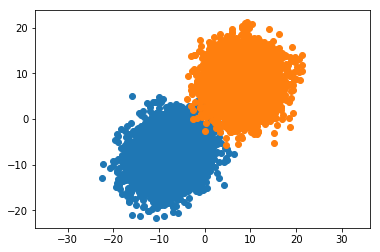

In [314]:
plt.scatter(alt[:, 0], alt[:, 1])
plt.scatter(null[:, 0], null[:, 1])
plt.axis('equal')

In [315]:
alt_obs = (alt[:, 0]-alt[:, 0].mean())*(alt[:, 1]-alt[:, 1].mean())
null_obs = (null[:, 0]-null[:, 0].mean())*(null[:, 1]-null[:, 1].mean())

In [316]:
df = pd.DataFrame()
df['geno'] = np.concatenate([[0 for i in range(N)] + [1 for i in range(N)]])
df['prod'] = np.concatenate([null_obs, alt_obs])

In [317]:
model = OLS(df['prod'], df['geno'])
res = model.fit()

In [318]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   prod   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     128.3
Date:                Tue, 18 Sep 2018   Prob (F-statistic):           1.46e-29
Time:                        11:45:31   Log-Likelihood:                -41350.
No. Observations:               10000   AIC:                         8.270e+04
Df Residuals:                    9999   BIC:                         8.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
geno           2.4222      0.214     11.327      0.0

### KO gene extraction

In [13]:
s = pd.Series(['afgafb.32434fdga', 'dafsf32.3243argfcas', 'c3.3423'])

### Debugging supervised training

In [18]:
h5_filename = '/Users/mincheolkim/Documents/raw_gene_bc_matrices_h5.h5'
metadata_filename = '/Users/mincheolkim/Documents/sample_metadata.txt'

gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    use_donors=True,
    use_labels=True,
    save_path='')

print('loaded dataset!')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 198
Number of cells kept after removing all zero cells: 198
Finished preprocessing CROP-seq dataset
loaded dataset!


In [ ]:
imp.reload(cs)
imp.reload(sdl)

In [ ]:
vae = VAEC(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
infer = cs.SupervisedVariationalInference(
    vae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=True,
    frequency=1)
infer.train(n_epochs=n_epochs, lr=lr)

In [ ]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
infer = VariationalInference(
    vae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=True,
    frequency=1)
infer.train(n_epochs=n_epochs, lr=lr)

### Create a shorter metadata file

In [7]:
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
metadata = pd.read_csv(metadata_filename, sep='\t')

In [8]:
metadata.louvain.value_counts()

0     51112
1     43035
2     41017
3     37939
4     36111
5     20898
6     19925
7     17919
8     14374
9      4851
10     1204
11      981
Name: louvain, dtype: int64

In [10]:
metadata.head(5)

,index,guide_cov,donor_cov,well_cov,numi_cov,multiplet_cov,nsnp_cov,percent_mito,n_counts,louvain
0,GCATGATCATCAGTCA-7,0,IGTB1840,7,1137,SNG,49,0.030783,485.21652,4
1,CGATCGGAGTGTTGAA-6,DPF2.65340430.AGAGGCGAGCATTGTAATTG_guide,IGTB884,6,5472,SNG,137,0.041667,1832.83230,0
2,CTACATTTCTGAGGGA-3,0,IGTB1901,3,3480,SNG,87,0.038218,1342.04440,0
3,TGGCGCAGTTAGTGGG-11,HDAC3.141628129.ACCTGGAGCACAATGCACGT_guide,IGTB1840,11,1732,SNG,54,0.025404,599.47550,1
4,TAGAGCTGTCTTCAAG-14,PRDM1.106088300.AGGATGCGGATATGACTCTG_guide,IGTB1901,14,4473,DBL,107,0.089873,1489.02300,8


In [7]:
control_pol2_cells = metadata[metadata.guide_cov.str.contains('POL') | (metadata.guide_cov == '0')]

In [8]:
sample_metadata = metadata.sample(200)

In [9]:
sample_metadata.to_csv(data_path + 'sample_metadata.txt', sep='\t')

In [39]:
control_pol2_cells.to_csv(data_path + 'control_pol2_metadata.txt', sep='\t')

### Testing the cropseq guide lookup

In [60]:
imp.reload(cs)
imp.reload(sdl)
# Load the dataset
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    use_donors=True,
    use_labels=True,
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset


### Testing data loader

In [9]:
# Load the dataset
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    use_donors=True,
    use_labels=True,
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset


In [43]:
imp.reload(cs)
imp.reload(sdl)
data_loader = sdl.SupervisedTrainTestDataLoaders(gene_dataset)

In [53]:
for tensors in data_loader['all']:
    sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
    print(np.unique(label, return_counts=True))
    break

(array([  6,   7,  16,  17,  18,  19,  20,  21,  23,  29,  31,  34,  38,
        39,  40,  41,  47,  49,  52,  56,  59,  60,  64,  67,  73,  75,
        76,  77,  79,  83,  87,  88,  91,  94,  97,  99, 100, 101, 110,
       111, 112, 113, 114, 116, 118, 128, 131, 132, 135, 136, 140, 145,
       146, 147, 149, 151, 153, 157, 158, 163, 167, 168, 169, 183, 186,
       194, 197, 200, 203, 207, 208, 213, 218, 221, 222, 225, 228, 230,
       247, 248, 249, 254, 256, 260, 261, 265, 266, 268, 269, 272, 273,
       275, 276, 278, 280]), array([1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 2, 2, 1, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 2,
       1, 1, 1, 3, 1, 3, 1]))


### misc

In [11]:
# Load the model
model_path = data_path + 'vae_model_test.model'
vae = torch.load(model_path, map_location=lambda storage, loc: storage)

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
# Load the dataset
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    use_donors=True,
    use_labels=True,
    save_path='')

Preprocessing CROP-seq dataset lalala
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset


In [12]:
# Create an inference class
use_batches=True
use_cuda=True
infer = VariationalInference(
    vae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=True,
    frequency=5)

In [18]:
gene_dataset.labels

array([[280],
       [ 40],
       [280],
       ...,
       [280],
       [ 40],
       [116]])

In [ ]:
data_loader = 

In [29]:
latent = []
for tensors in infer.data_loaders['sequential']:
    sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
    latent += [vae.sample_from_posterior_z(sample_batch, y=label)]
    break

In [75]:
torch.distributions.Normal(torch.tensor([1.0, 1.0]), torch.tensor([1.0, 1.0])).rsample()

tensor([1.8844, 0.3331])

In [82]:
x = sample_batch

In [122]:
q = vae.z_encoder.encoder(x)[0, :]

In [130]:
var = vae.z_encoder.var_encoder(vae.z_encoder.encoder(x)[10, :])

In [137]:
torch.exp(torch.clamp(var, -5, 5))

tensor([0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067])

In [120]:
q

tensor([[ 2.5654,  0.0000,  0.0000,  ...,  2.5109,  8.8773,  0.7601],
        [ 0.0000,  0.0000,  0.0000,  ..., 15.8079,  0.0000,  0.0000],
        [ 7.5503,  0.0000,  0.0000,  ...,  1.1686, 13.2909,  5.0562],
        ...,
        [ 8.6540, 18.0296,  0.0000,  ..., 11.6259,  9.6111,  2.0203],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.4792,  1.8050,  0.0000],
        [ 2.3887,  0.0000,  0.0000,  ...,  6.2484,  9.2351,  0.0000]])

In [99]:
vae.z_encoder.var_encoder.weight.shape

torch.Size([10, 128])

In [93]:
qz_m

tensor([[ -81.9397,  -76.3242,  -16.1560,  ...,  124.1240,  271.2110,
          300.8079],
        [-163.5321,   72.3545, -374.5663,  ...,  271.3742,  156.3855,
          163.5798],
        [ -92.2339,  -57.9898,  -87.6369,  ...,  242.6978,  124.5783,
          185.8195],
        ...,
        [  19.6231,  -21.3858, -393.1049,  ...,  475.5630, -191.9860,
          172.7761],
        [-153.8749,  -48.3089, -190.6447,  ...,  183.3277,  372.9952,
          343.9473],
        [-163.2225, -111.5427,  -87.5208,  ...,  187.7696,  255.4589,
          297.7498]])

In [62]:
vae.sample_from_posterior_z(sample_batch, y=label)[0, :]

tensor([10.2543, -7.8392, -4.8887, -5.5117, -9.9770, 18.0329, 36.2084,  3.4973,
        16.5866, 28.1041])

In [44]:
sample_batch.shape

torch.Size([128, 32738])

In [35]:
latent[0].shape

torch.Size([128, 10])

In [40]:
latent[0].data.numpy()[3, :]

array([-0.84022033,  4.3386154 , -3.2906535 , -4.476451  , -2.4687972 ,
       24.499353  , 14.695851  , 30.992464  , 20.389019  ,  5.676299  ],
      dtype=float32)

In [24]:
temp = sample_batch.data.numpy()

In [ ]:
latent 